In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
import os
import cv2
from PIL import Image
import torchvision
import torchvision.transforms as T
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torch.load('/home/shiwon/OA_HI_DER/ckpts/ckpt_task_4.pt').to(device)
model.eval()

DERNet(
  (convnets): ModuleList(
    (0-4): 5 x ResNet(
      (conv1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0)

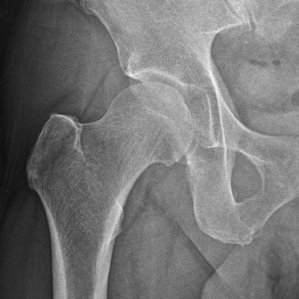

In [3]:
val_img = pd.read_csv('/home/shiwon/OA_HI_DER/data/folds/hip/e1_val_hip.csv', header=None)
img_idx = 190
img_path = val_img[0][img_idx-1]

pil_img = Image.open(img_path).convert('RGB')
pil_img

In [4]:
def normalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.sub(mean).div(std)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return self.do(tensor)
    
    def do(self, tensor):
        return normalize(tensor, self.mean, self.std)
    
    # def undo(self, tensor):
    #     return denormalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.interpolate(torch_img, size=(224, 224), mode='bilinear', align_corners=False) # (1, 3, 224, 224)
normed_torch_img = normalizer(torch_img)

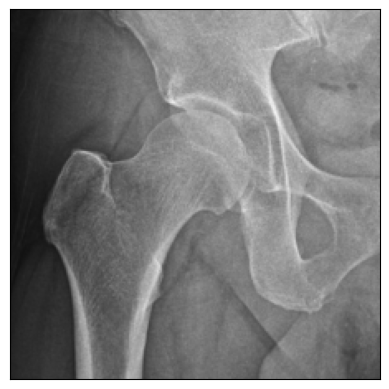

In [6]:
# Image check.

img = np.transpose(torch_img.cpu().numpy().squeeze(), (1, 2, 0)) # (224, 224, 3)
plt.imshow(img)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

In [7]:
import shutil

saved_loc = os.path.join('./grad_cam/', str(img_idx))
if os.path.exists(saved_loc):
    shutil.rmtree(saved_loc)
os.mkdir(saved_loc)

print("결과 저장 위치: ", saved_loc)

결과 저장 위치:  ./grad_cam/190


Image index: 190, Predicted label: 16, Probability: 0.298


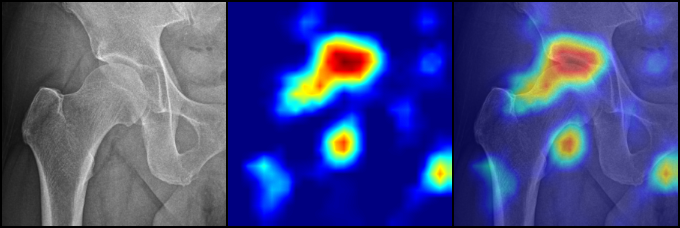

In [8]:
# activations
feature_blobs = []

# gradients
backward_feature = []

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())
    

# Grad-CAM
def backward_hook(module, input, output):
    backward_feature.append(output[0])
    

# model._modules['convnets'][-1].layer4.register_forward_hook(hook_feature)
# model._modules['convnets'][-1].layer4.register_backward_hook(backward_hook)

model.convnets[4].layer4.register_forward_hook(hook_feature)
model.convnets[4].layer4.register_backward_hook(backward_hook)

# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].cpu().detach().numpy()) # [1000, 512]

# Prediction
# logit = model(normed_torch_img)[1]
# logit = model(normed_torch_img)[2]
logit = model(normed_torch_img)[3]
# h_x = F.softmax(logit, dim=1).data.squeeze() # softmax 적용
h_x = torch.softmax(logit, dim=1).data.squeeze()

probs, idx = h_x.sort(0, True)
msg = 'Image index: %d, Predicted label: %d, Probability: %.3f' % (img_idx, idx[0].item(), probs[0].item())
print(msg)

pred = open('./grad_cam/predictions.txt', 'a')
pred.write(msg + '\n')
pred.close()


# ============================= #
# ==== Grad-CAM main lines ==== #
# ============================= #


score = logit[:, idx[0]].squeeze() # 예측값 y^c
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행
    
activations = torch.Tensor(feature_blobs[0]).to(device) # (1, 512, 7, 7), forward activations
gradients = backward_feature[0] # (1, 512, 7, 7), backward gradients
b, k, u, v = gradients.size()

alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
grad_cam_map = F.interpolate(grad_cam_map, size=(224, 224), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 224, 224), min-max scaling

# grad_cam_map.squeeze() : (224, 224)
grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET) # (224, 224, 3), numpy 
grad_heatmap = torch.from_numpy(grad_heatmap).permute(2, 0, 1).float().div(255) # (3, 244, 244)
b, g, r = grad_heatmap.split(1)
grad_heatmap = torch.cat([r, g, b]) # (3, 244, 244), opencv's default format is BGR, so we need to change it as RGB format.

# save_image(grad_heatmap, os.path.join(saved_loc, "grad_cam.jpg"))
transform = T.ToPILImage()
img = transform(grad_heatmap)
img.save(os.path.join(saved_loc, 'grad_cam.jpg'), dpi=(300, 300))

grad_result = grad_heatmap + torch_img.cpu() # (1, 3, 244, 244)
grad_result = grad_result.div(grad_result.max()).squeeze() # (3, 244, 244)

# save_image(grad_result, os.path.join(saved_loc, "overlay.jpg"))
transform = T.ToPILImage()
img = transform(grad_result)
img.save(os.path.join(saved_loc, 'overlay.jpg'), dpi=(300, 300))

image_list = []

image_list.append(torch.stack([torch_img.squeeze().cpu(), grad_heatmap, grad_result], 0)) # (3, 3, 244, 244)

images = make_grid(torch.cat(image_list, 0), nrow=3)

output_dir = saved_loc
os.makedirs(output_dir, exist_ok=True)
output_name = 'results.png'
output_path = os.path.join(output_dir, output_name)

# save_image(images, output_path)
transform = T.ToPILImage()
img = transform(images)
img.save(output_path, dpi=(300, 300))

Image.open(output_path)

In [9]:
logit = model(normed_torch_img)
logit

({'logits': tensor([[  3.0815,  -5.7232,  -8.8354,  16.7966,   4.5325,  10.9336,   2.6200,
            -7.4250,  -1.0083,   6.8050,   5.8526, -10.7103,  -7.6207,   2.1084,
            -5.8155,   6.3463,   5.4901,  18.2036,  -9.4070,  -0.2887]],
         device='cuda:0', grad_fn=<AddmmBackward0>),
  'aux_logits': tensor([[-2.1449,  0.9020,  0.0425, -0.7594, -1.7425]], device='cuda:0',
         grad_fn=<AddmmBackward0>),
  'features': tensor([[0.5697, 0.9019, 0.3969,  ..., 0.6383, 0.7328, 0.5024]],
         device='cuda:0', grad_fn=<CatBackward0>)},
 tensor([[-0.5256,  2.7079,  1.6960,  2.0240,  0.5176,  1.2699,  0.1832,  3.2333,
           5.8427,  6.6985]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[-1.1829, -2.6359, -0.0826, -3.2961, -4.3674, -1.9547, -2.1994, -1.0872,
          -2.1153, -1.1315, -1.5169, -2.5262,  2.3282,  1.6386,  0.5722]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ 2.7283,  0.4688,  3.5818,  2.2195, -3.0526, -2.1591, -0.6614, -3.1007,

In [10]:
grad_cam_map.shape

torch.Size([1, 1, 224, 224])

In [11]:
heatmap = grad_cam_map

In [12]:
heatmap /= torch.max(heatmap)
heatmap

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [13]:
heatmap = heatmap.squeeze()

In [14]:
heatmap = heatmap.cpu()

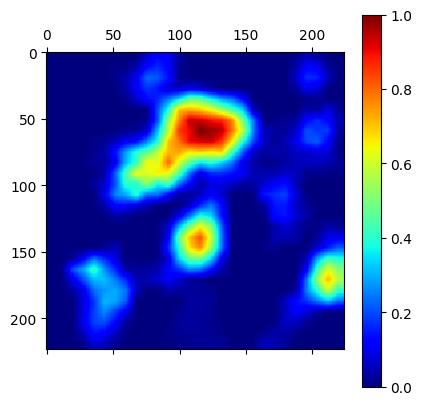

In [15]:
im = plt.matshow(heatmap, cmap='jet')
plt.colorbar(im)

In [16]:
import numpy as np

def binarize_attention_map(attention_map, threshold):
    binary_map = np.zeros_like(attention_map)  # Create a binary map with the same shape as the attention map
    
    # Set pixels above the threshold to 1 (significant)
    binary_map[attention_map >= threshold] = 1
    
    return binary_map

threshold = 0.8

binary_map = binarize_attention_map(heatmap, threshold)

In [17]:
def calculate_percentage(binary_map):
    total_pixels = binary_map.size
    significant_pixels = np.count_nonzero(binary_map == 1)
    
    percentage = (significant_pixels / total_pixels) * 100
    
    return percentage

# Example usage
percentage = calculate_percentage(binary_map)
print(f"Percentage of significant pixels: {percentage}%")


Percentage of significant pixels: 1.6741071428571428%


In [18]:
resize = T.Resize(224)

re_img = resize(pil_img)

(-0.5, 223.5, 223.5, -0.5)

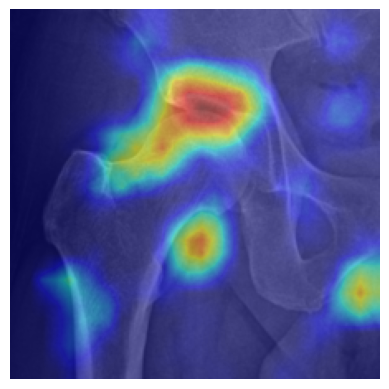

In [19]:
plt.imshow(re_img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')